# Deep Reinforcement Learning for Portfolio Optimization - EIIE Architecture


This experiement demonstrates the application of deep reinforcement learning (DRL) techniques for portfolio optimization.


- Policy network architecture: **EIIE backbone**
- Uses vanilla **Policy Gradient**

## Dependencies


In [1]:
# ! pip install pandas numpy matplotlib \
#                stable-baselines3 \
#                PyPortfolioOpt \
#                pandas_market_calendars quantstats gymnasium \
#                git+https://github.com/AI4Finance-Foundation/FinRL.git -q

In [2]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from scipy.optimize import minimize

import torch

from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import (
    PortfolioOptimizationEnv,
)
from finrl.agents.portfolio_optimization.models import DRLAgent as POAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

In [3]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [5]:
experiment_name = "eiie_pg"
results_dir = f"results/models/{experiment_name}"
os.makedirs(results_dir, exist_ok=True)

## Data loading and pre-processing


Define training and trading/test periods


In [6]:
start_date = "2015-01-01"
end_date = (datetime.now() - pd.Timedelta(days=1)).strftime("%Y-%m-%d")  # Yesterday

trade_period = 2  # 2 years for testing
train_period = 10  # 10 years for training

train_end_date = (
    datetime.strptime(end_date, "%Y-%m-%d") - timedelta(days=trade_period * 365)
).strftime("%Y-%m-%d")
train_start_date = (
    datetime.strptime(train_end_date, "%Y-%m-%d") - timedelta(days=train_period * 365)
).strftime("%Y-%m-%d")
test_start_date = (
    datetime.strptime(train_end_date, "%Y-%m-%d") + timedelta(days=1)
).strftime("%Y-%m-%d")

train_dates = (train_start_date, train_end_date)
test_dates = (test_start_date, end_date)

print(f"Training period: {train_dates}")
print(f"Testing period: {test_dates}")

Training period: ('2013-05-07', '2023-05-05')
Testing period: ('2023-05-06', '2025-05-04')


- Fetch historical stock data for a given list of tickers within a specified date range.
- We use the DOW_30_TICKER stocks
- The data includes `date`, `close`, `high`, `low`, `open`, `volume`, and `tic` (ticker symbol).


In [7]:
def download_data(tickers, start_date, end_date):
    print(f"Downloading {start_date} → {end_date}")
    return YahooDownloader(
        start_date=start_date, end_date=end_date, ticker_list=tickers
    ).fetch_data()

tickers = config_tickers.DOW_30_TICKER
raw_df = download_data(tickers, start_date, end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (76911, 8)


---

### Feature Engineering

We apply feature engineering to the dataset of stock data:

- Add technical indicators (e.g., moving averages, RSI).
- Calculate turbulence indicators, which measure market volatility.

This Enhance the dataset with features that are critical for modeling market dynamics and making informed trading decisions.


In [8]:
def preprocess_data(df):
    fe = FeatureEngineer(use_technical_indicator=True, use_turbulence=True)
    return fe.preprocess_data(df)

df_feat = preprocess_data(raw_df)

Successfully added technical indicators
Successfully added turbulence index


## Covariance & Returns for State


- Calculate the rolling covariance matrices and daily returns for the given dataset of stock prices.
- This prepares the state representation (the state of the portfolio) for the RL models in the RL environments for portfolio optimization.
- The **rolling covariance matrices** (`cov_list`) capture the relationships between asset returns, while the daily returns (`return_list`) provide information about recent price movements.
- These metrics are critical for modeling the dynamics of the financial market and making informed trading decisions.


In [9]:
def compute_covariance_and_returns(df_feat, lookback=252):
    df_sorted = df_feat.sort_values(["date", "tic"], ignore_index=True)
    df_sorted.index = df_sorted.date.factorize()[0]
    cov_list, return_list = [], []

    dates = df_sorted.date.unique()
    for i in range(lookback, len(dates)):
        win = df_sorted.loc[i - lookback : i]
        pm = win.pivot_table(index="date", columns="tic", values="close")
        rm = pm.pct_change().dropna()
        cov_list.append(rm.cov().values)
        return_list.append(rm)
    df_cov = pd.DataFrame(
        {"date": dates[lookback:], "cov_list": cov_list, "return_list": return_list}
    )

    return pd.merge(df_feat, df_cov, on="date", how="left").dropna(subset=["cov_list"])


df_all = compute_covariance_and_returns(df_feat)

## Train/Trade split


In [10]:
def split_data(df_all, train_dates, test_dates):
    train = data_split(df_all, *train_dates)
    test = data_split(df_all, *test_dates)
    return train, test


train_df, test_df = split_data(df_all, train_dates, test_dates)

## Environment setup


- Create instances of the **PortfolioOptimizationEnv** class for both training and testing datasets.
- It also wrap the training environment for use with Stable-Baselines3 (SB3).


In [11]:
def initialize_portfolio_env(df):
    env = PortfolioOptimizationEnv(
        df,
        initial_amount=100_000,
        comission_fee_pct=0.0025,
        time_window=50,
        features=["close", "high", "low"],
        normalize_df=None,
        new_gym_api=True,
    )

    env.df = df.reset_index(drop=True)

    return env


train_env = initialize_portfolio_env(train_df)

## Training


- Set PolicyGradient algorithm and EIIE architecture arguments


In [12]:
model_kwargs = {"lr": 0.01, "policy": EIIE}
# Set EIIE architecture arguments
policy_kwargs = {"k_size": 3, "time_window": 50}

model = POAgent(train_env).get_model("pg", device, model_kwargs, policy_kwargs)

- Train the model


In [13]:
def train():
    start_time = time.time()

    trained_model = POAgent.train_model(model, episodes=64)

    end_time = time.time()
    training_duration = (end_time - start_time) / 60
    print(f"Training completed in {training_duration:.2f} minutes.")
    
    return trained_model, training_duration

In [14]:
# TODO: Turn to False after first run to avoid retraining and just analyse the results
retrain = True

model_path = f"{results_dir}/eeie_pg.pth"

In [15]:
if retrain:
    trained_model, training_duration = train()

  0%|          | 0/64 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 107874.2578125
Final accumulative portfolio value: 1.0787426233291626
Maximum DrawDown: -0.7929161734364495
Sharpe ratio: 0.19507891462537283


  2%|▏         | 1/64 [00:19<20:48, 19.82s/it]

Initial portfolio value:100000
Final portfolio value: 138992.359375
Final accumulative portfolio value: 1.3899235725402832
Maximum DrawDown: -0.7925547255127522
Sharpe ratio: 0.30922270137187335


  3%|▎         | 2/64 [00:40<20:57, 20.28s/it]

Initial portfolio value:100000
Final portfolio value: 201053.59375
Final accumulative portfolio value: 2.010535955429077
Maximum DrawDown: -0.7792005882921816
Sharpe ratio: 0.46055272806645364


  5%|▍         | 3/64 [01:00<20:21, 20.02s/it]

Initial portfolio value:100000
Final portfolio value: 205132.453125
Final accumulative portfolio value: 2.0513246059417725
Maximum DrawDown: -0.7792005717466592
Sharpe ratio: 0.4686240084875953


  6%|▋         | 4/64 [01:18<19:29, 19.49s/it]

Initial portfolio value:100000
Final portfolio value: 153383.953125
Final accumulative portfolio value: 1.5338395833969116
Maximum DrawDown: -0.7808868737544259
Sharpe ratio: 0.3528344888131361


  8%|▊         | 5/64 [01:37<18:42, 19.03s/it]

Initial portfolio value:100000
Final portfolio value: 248993.265625
Final accumulative portfolio value: 2.4899325370788574
Maximum DrawDown: -0.6420589851866174
Sharpe ratio: 0.5890528972703165


  9%|▉         | 6/64 [01:55<18:14, 18.87s/it]

Initial portfolio value:100000
Final portfolio value: 151688.296875
Final accumulative portfolio value: 1.5168830156326294
Maximum DrawDown: -0.7708562057775894
Sharpe ratio: 0.3478958436062451


 11%|█         | 7/64 [02:13<17:43, 18.67s/it]

Initial portfolio value:100000
Final portfolio value: 157597.671875
Final accumulative portfolio value: 1.5759767293930054
Maximum DrawDown: -0.7709596117258932
Sharpe ratio: 0.3650870515217914


 12%|█▎        | 8/64 [02:33<17:50, 19.11s/it]

Initial portfolio value:100000
Final portfolio value: 157428.265625
Final accumulative portfolio value: 1.5742826461791992
Maximum DrawDown: -0.7709620415898746
Sharpe ratio: 0.36458455121606065


 14%|█▍        | 9/64 [02:54<18:00, 19.65s/it]

Initial portfolio value:100000
Final portfolio value: 153886.75
Final accumulative portfolio value: 1.538867473602295
Maximum DrawDown: -0.7772655211520731
Sharpe ratio: 0.35433629164018365


 16%|█▌        | 10/64 [03:15<17:58, 19.96s/it]

Initial portfolio value:100000
Final portfolio value: 209826.15625
Final accumulative portfolio value: 2.098261594772339
Maximum DrawDown: -0.69187789100681
Sharpe ratio: 0.49895893877739256


 17%|█▋        | 11/64 [03:35<17:35, 19.91s/it]

Initial portfolio value:100000
Final portfolio value: 201435.9375
Final accumulative portfolio value: 2.014359474182129
Maximum DrawDown: -0.6919518762975738
Sharpe ratio: 0.4802931198641268


 19%|█▉        | 12/64 [03:55<17:14, 19.90s/it]

Initial portfolio value:100000
Final portfolio value: 202528.5
Final accumulative portfolio value: 2.025285005569458
Maximum DrawDown: -0.6958203468241213
Sharpe ratio: 0.48222345688801055


 20%|██        | 13/64 [04:15<16:59, 19.99s/it]

Initial portfolio value:100000
Final portfolio value: 221383.71875
Final accumulative portfolio value: 2.213837146759033
Maximum DrawDown: -0.6312401997603527
Sharpe ratio: 0.530426773663808


 22%|██▏       | 14/64 [04:35<16:37, 19.95s/it]

Initial portfolio value:100000
Final portfolio value: 181346.3125
Final accumulative portfolio value: 1.8134630918502808
Maximum DrawDown: -0.7181031611425506
Sharpe ratio: 0.42872911266192787


 23%|██▎       | 15/64 [04:54<16:14, 19.89s/it]

Initial portfolio value:100000
Final portfolio value: 177675.921875
Final accumulative portfolio value: 1.7767592668533325
Maximum DrawDown: -0.7404863895161954
Sharpe ratio: 0.41873857414621085


 25%|██▌       | 16/64 [05:14<15:53, 19.87s/it]

Initial portfolio value:100000
Final portfolio value: 180232.671875
Final accumulative portfolio value: 1.8023266792297363
Maximum DrawDown: -0.7410182030771941
Sharpe ratio: 0.4251237479093425


 27%|██▋       | 17/64 [05:34<15:31, 19.82s/it]

Initial portfolio value:100000
Final portfolio value: 181098.359375
Final accumulative portfolio value: 1.8109835386276245
Maximum DrawDown: -0.7404212999227895
Sharpe ratio: 0.42726094771294704


 28%|██▊       | 18/64 [05:54<15:11, 19.81s/it]

Initial portfolio value:100000
Final portfolio value: 181916.265625
Final accumulative portfolio value: 1.8191626071929932
Maximum DrawDown: -0.7404779833328294
Sharpe ratio: 0.42928475602029476


 30%|██▉       | 19/64 [06:14<14:53, 19.86s/it]

Initial portfolio value:100000
Final portfolio value: 183585.296875
Final accumulative portfolio value: 1.8358529806137085
Maximum DrawDown: -0.7404910647668289
Sharpe ratio: 0.4333528297645538


 31%|███▏      | 20/64 [06:33<14:32, 19.82s/it]

Initial portfolio value:100000
Final portfolio value: 184672.734375
Final accumulative portfolio value: 1.8467273712158203
Maximum DrawDown: -0.7405647321086036
Sharpe ratio: 0.4360076517380696


 33%|███▎      | 21/64 [06:53<14:09, 19.75s/it]

Initial portfolio value:100000
Final portfolio value: 185935.4375
Final accumulative portfolio value: 1.8593543767929077
Maximum DrawDown: -0.7405158794579368
Sharpe ratio: 0.43904533285169894


 34%|███▍      | 22/64 [07:13<13:49, 19.75s/it]

Initial portfolio value:100000
Final portfolio value: 179780.40625
Final accumulative portfolio value: 1.7978041172027588
Maximum DrawDown: -0.7495980127375633
Sharpe ratio: 0.4243602859848672


 36%|███▌      | 23/64 [07:32<13:28, 19.72s/it]

Initial portfolio value:100000
Final portfolio value: 236143.921875
Final accumulative portfolio value: 2.3614392280578613
Maximum DrawDown: -0.5832063573009321
Sharpe ratio: 0.5638194011221926


 38%|███▊      | 24/64 [07:52<13:08, 19.72s/it]

Initial portfolio value:100000
Final portfolio value: 184709.546875
Final accumulative portfolio value: 1.8470954895019531
Maximum DrawDown: -0.6326474904337808
Sharpe ratio: 0.44530665797570845


 39%|███▉      | 25/64 [08:12<12:50, 19.76s/it]

Initial portfolio value:100000
Final portfolio value: 246983.046875
Final accumulative portfolio value: 2.4698305130004883
Maximum DrawDown: -0.5818017816335463
Sharpe ratio: 0.587134138104813


 41%|████      | 26/64 [08:32<12:31, 19.77s/it]

Initial portfolio value:100000
Final portfolio value: 254736.4375
Final accumulative portfolio value: 2.5473644733428955
Maximum DrawDown: -0.5835095823212062
Sharpe ratio: 0.6015377723372504


 42%|████▏     | 27/64 [08:51<12:11, 19.76s/it]

Initial portfolio value:100000
Final portfolio value: 289683.5625
Final accumulative portfolio value: 2.8968355655670166
Maximum DrawDown: -0.5828651929876416
Sharpe ratio: 0.664709149116109


 44%|████▍     | 28/64 [09:11<11:50, 19.74s/it]

Initial portfolio value:100000
Final portfolio value: 237135.640625
Final accumulative portfolio value: 2.37135648727417
Maximum DrawDown: -0.6239825611361669
Sharpe ratio: 0.5632641956441331


 45%|████▌     | 29/64 [09:31<11:33, 19.82s/it]

Initial portfolio value:100000
Final portfolio value: 265726.125
Final accumulative portfolio value: 2.6572611331939697
Maximum DrawDown: -0.6240469365820769
Sharpe ratio: 0.6179361640038932


 47%|████▋     | 30/64 [09:51<11:15, 19.85s/it]

Initial portfolio value:100000
Final portfolio value: 282626.3125
Final accumulative portfolio value: 2.826263189315796
Maximum DrawDown: -0.5818158527499342
Sharpe ratio: 0.6520008918255972


 48%|████▊     | 31/64 [10:11<10:56, 19.90s/it]

Initial portfolio value:100000
Final portfolio value: 269293.875
Final accumulative portfolio value: 2.692938804626465
Maximum DrawDown: -0.624041580705016
Sharpe ratio: 0.6243586816797493


 50%|█████     | 32/64 [10:30<10:29, 19.68s/it]

Initial portfolio value:100000
Final portfolio value: 259278.015625
Final accumulative portfolio value: 2.592780113220215
Maximum DrawDown: -0.6240329347694776
Sharpe ratio: 0.6056476758454732


 52%|█████▏    | 33/64 [10:49<10:05, 19.54s/it]

Initial portfolio value:100000
Final portfolio value: 266946.21875
Final accumulative portfolio value: 2.669462203979492
Maximum DrawDown: -0.6200611184914675
Sharpe ratio: 0.6204751934833739


 53%|█████▎    | 34/64 [11:09<09:43, 19.43s/it]

Initial portfolio value:100000
Final portfolio value: 283704.5
Final accumulative portfolio value: 2.8370449542999268
Maximum DrawDown: -0.5834938955085059
Sharpe ratio: 0.6538738307245306


 55%|█████▍    | 35/64 [11:28<09:21, 19.36s/it]

Initial portfolio value:100000
Final portfolio value: 297965.40625
Final accumulative portfolio value: 2.97965407371521
Maximum DrawDown: -0.5818740784097111
Sharpe ratio: 0.6776486462841828


 56%|█████▋    | 36/64 [11:47<08:58, 19.25s/it]

Initial portfolio value:100000
Final portfolio value: 229405.328125
Final accumulative portfolio value: 2.294053316116333
Maximum DrawDown: -0.5959091397701067
Sharpe ratio: 0.5498734265999158


 58%|█████▊    | 37/64 [12:06<08:36, 19.14s/it]

Initial portfolio value:100000
Final portfolio value: 164548.515625
Final accumulative portfolio value: 1.6454851627349854
Maximum DrawDown: -0.4697440303621806
Sharpe ratio: 0.38968583026812215


 59%|█████▉    | 38/64 [12:25<08:15, 19.06s/it]

Initial portfolio value:100000
Final portfolio value: 275043.65625
Final accumulative portfolio value: 2.750436544418335
Maximum DrawDown: -0.5835903671199432
Sharpe ratio: 0.6391150170842544


 61%|██████    | 39/64 [12:44<07:56, 19.04s/it]

Initial portfolio value:100000
Final portfolio value: 293265.96875
Final accumulative portfolio value: 2.93265962600708
Maximum DrawDown: -0.5820103268764711
Sharpe ratio: 0.6701769787997367


 62%|██████▎   | 40/64 [13:03<07:38, 19.09s/it]

Initial portfolio value:100000
Final portfolio value: 289786.3125
Final accumulative portfolio value: 2.8978631496429443
Maximum DrawDown: -0.5818127713444285
Sharpe ratio: 0.6644556629126118


 64%|██████▍   | 41/64 [13:22<07:22, 19.26s/it]

Initial portfolio value:100000
Final portfolio value: 291954.40625
Final accumulative portfolio value: 2.919543981552124
Maximum DrawDown: -0.5819645361251129
Sharpe ratio: 0.6680751095931051


 66%|██████▌   | 42/64 [13:42<07:02, 19.22s/it]

Initial portfolio value:100000
Final portfolio value: 297326.875
Final accumulative portfolio value: 2.973268747329712
Maximum DrawDown: -0.5818014789135066
Sharpe ratio: 0.6769228845885991


 67%|██████▋   | 43/64 [14:02<06:49, 19.51s/it]

Initial portfolio value:100000
Final portfolio value: 293744.375
Final accumulative portfolio value: 2.937443733215332
Maximum DrawDown: -0.5835547149557769
Sharpe ratio: 0.6711631532278272


 69%|██████▉   | 44/64 [14:21<06:30, 19.54s/it]

Initial portfolio value:100000
Final portfolio value: 308198.21875
Final accumulative portfolio value: 3.081982135772705
Maximum DrawDown: -0.5818011162817656
Sharpe ratio: 0.6944948116033669


 70%|███████   | 45/64 [14:42<06:15, 19.76s/it]

Initial portfolio value:100000
Final portfolio value: 306698.8125
Final accumulative portfolio value: 3.066988229751587
Maximum DrawDown: -0.5827024786284498
Sharpe ratio: 0.6922520864734529


 72%|███████▏  | 46/64 [15:02<05:56, 19.82s/it]

Initial portfolio value:100000
Final portfolio value: 309182.40625
Final accumulative portfolio value: 3.0918240547180176
Maximum DrawDown: -0.581801023262563
Sharpe ratio: 0.6960571437242027


 73%|███████▎  | 47/64 [15:22<05:38, 19.92s/it]

Initial portfolio value:100000
Final portfolio value: 311908.25
Final accumulative portfolio value: 3.119082450866699
Maximum DrawDown: -0.5818016203690801
Sharpe ratio: 0.7003420843791878


 75%|███████▌  | 48/64 [15:42<05:18, 19.88s/it]

Initial portfolio value:100000
Final portfolio value: 313621.65625
Final accumulative portfolio value: 3.136216640472412
Maximum DrawDown: -0.5818011283037942
Sharpe ratio: 0.702945907643509


 77%|███████▋  | 49/64 [16:02<04:58, 19.93s/it]

Initial portfolio value:100000
Final portfolio value: 315177.34375
Final accumulative portfolio value: 3.151773452758789
Maximum DrawDown: -0.5818060204575757
Sharpe ratio: 0.7053774529099506


 78%|███████▊  | 50/64 [16:22<04:39, 19.98s/it]

Initial portfolio value:100000
Final portfolio value: 315573.09375
Final accumulative portfolio value: 3.155730962753296
Maximum DrawDown: -0.5818022968787641
Sharpe ratio: 0.7060602972940256


 80%|███████▉  | 51/64 [16:43<04:23, 20.28s/it]

Initial portfolio value:100000
Final portfolio value: 317179.1875
Final accumulative portfolio value: 3.1717917919158936
Maximum DrawDown: -0.581802277184039
Sharpe ratio: 0.7084983176110272


 81%|████████▏ | 52/64 [17:03<04:04, 20.36s/it]

Initial portfolio value:100000
Final portfolio value: 318174.34375
Final accumulative portfolio value: 3.1817433834075928
Maximum DrawDown: -0.5818024471963614
Sharpe ratio: 0.7101039365752447


 83%|████████▎ | 53/64 [17:23<03:43, 20.28s/it]

Initial portfolio value:100000
Final portfolio value: 319020.65625
Final accumulative portfolio value: 3.190206527709961
Maximum DrawDown: -0.5818013129496614
Sharpe ratio: 0.7114359721600482


 84%|████████▍ | 54/64 [17:43<03:20, 20.04s/it]

Initial portfolio value:100000
Final portfolio value: 319349.53125
Final accumulative portfolio value: 3.193495273590088
Maximum DrawDown: -0.5818143292363989
Sharpe ratio: 0.7119183744830145


 86%|████████▌ | 55/64 [18:03<03:01, 20.22s/it]

Initial portfolio value:100000
Final portfolio value: 319744.78125
Final accumulative portfolio value: 3.1974477767944336
Maximum DrawDown: -0.5818176855796264
Sharpe ratio: 0.7125999225946723


 88%|████████▊ | 56/64 [18:24<02:42, 20.28s/it]

Initial portfolio value:100000
Final portfolio value: 322243.125
Final accumulative portfolio value: 3.222431182861328
Maximum DrawDown: -0.5818172470458454
Sharpe ratio: 0.7165617937570442


 89%|████████▉ | 57/64 [18:44<02:22, 20.37s/it]

Initial portfolio value:100000
Final portfolio value: 322764.21875
Final accumulative portfolio value: 3.227642297744751
Maximum DrawDown: -0.5818083707717538
Sharpe ratio: 0.7173586124369681


 91%|█████████ | 58/64 [19:04<02:01, 20.25s/it]

Initial portfolio value:100000
Final portfolio value: 321627.1875
Final accumulative portfolio value: 3.2162718772888184
Maximum DrawDown: -0.5828042724427169
Sharpe ratio: 0.7156592280593921


 92%|█████████▏| 59/64 [19:25<01:41, 20.26s/it]

Initial portfolio value:100000
Final portfolio value: 315605.875
Final accumulative portfolio value: 3.1560587882995605
Maximum DrawDown: -0.5818009301085652
Sharpe ratio: 0.7064125134060926


 94%|█████████▍| 60/64 [19:44<01:19, 19.85s/it]

Initial portfolio value:100000
Final portfolio value: 322847.65625
Final accumulative portfolio value: 3.2284765243530273
Maximum DrawDown: -0.5818010579196992
Sharpe ratio: 0.7174816647638119


 95%|█████████▌| 61/64 [20:03<00:59, 19.68s/it]

Initial portfolio value:100000
Final portfolio value: 269437.71875
Final accumulative portfolio value: 2.6943771839141846
Maximum DrawDown: -0.5835909306372242
Sharpe ratio: 0.6293974505132556


 97%|█████████▋| 62/64 [20:22<00:38, 19.45s/it]

Initial portfolio value:100000
Final portfolio value: 237201.828125
Final accumulative portfolio value: 2.372018337249756
Maximum DrawDown: -0.42045123767925274
Sharpe ratio: 0.6681517331803233


 98%|█████████▊| 63/64 [20:41<00:19, 19.39s/it]

Initial portfolio value:100000
Final portfolio value: 234563.171875
Final accumulative portfolio value: 2.3456318378448486
Maximum DrawDown: -0.3244627326067232
Sharpe ratio: 0.7546181583077712


100%|██████████| 64/64 [21:01<00:00, 19.71s/it]

Training completed in 21.02 minutes.


In [16]:
if retrain:
    # Save the trained model
    torch.save(trained_model.train_policy.state_dict(),model_path)
    print(f"Model saved to {model_path}")
    
    # Save training times
    training_times_df = pd.DataFrame(
        [{"model": "EIIE_PG", "training_duration (min)": training_duration}]
    )
    training_times_df.to_csv(f"{results_dir}/training_times.csv", index=False)

    # Display training summary
    print("Training summary:")
    display(training_times_df)

Model saved to results/models/eiie_pg/eeie_pg.pth
Training summary:


,model,training_duration (min)
0,EIIE_PG,21.020815


## Backtesting


In [17]:
policy = EIIE(time_window=50, device=device)
policy.load_state_dict(torch.load(model_path, map_location=device))
print("Model loaded and ready for evaluation.")
print("Evaluating model on test data...")

test_env = initialize_portfolio_env(test_df.reset_index(drop=True))

Model loaded and ready for evaluation.
Evaluating model on test data...


In [18]:
def portfolio_test(env, policy, initial_last_action=None):
    obs, _ = env.reset()
    obs = np.asarray(obs, dtype=np.float32)

    # Initial last_action
    if initial_last_action is None:
        action_dim = env.action_space.shape[0]
        last_action = np.ones(action_dim, dtype=np.float32) / action_dim
    else:
        last_action = np.asarray(initial_last_action).flatten().astype(np.float32)

    done = False
    transitions = []

    while not done:
        # Create batches
        obs_batch = obs[None, ...]
        la_batch = last_action[None, ...]

        # Policy forward
        action = policy(obs_batch, la_batch)
        action = np.asarray(action).flatten().astype(np.float32)

        # Step
        next_obs, reward, terminated, truncated, info = env.step(action)
        done = bool(terminated or truncated)

        next_obs = np.asarray(next_obs, dtype=np.float32)

        # Record
        transitions.append(
            {
                "obs": obs,
                "last_action": last_action,
                "action": action,
                "reward": float(reward),
                "info": info,
            }
        )

        # Advance
        obs = next_obs
        last_action = action

    return transitions


transitions = portfolio_test(test_env, policy)

print(f"Collected {len(transitions)} steps.")
print("Rewards:", [t["reward"] for t in transitions])

Initial portfolio value:100000
Final portfolio value: 119732.6171875
Final accumulative portfolio value: 1.1973261833190918
Maximum DrawDown: -0.1449142242493291
Sharpe ratio: 0.8137727063514602
Collected 450 steps.
Rewards: [0.0047187162563204765, 0.0020179639104753733, 0.003721575252711773, 0.0014973392244428396, 0.004121026024222374, -0.007465323433279991, 0.0059018866159021854, 0.001977156847715378, -3.993519385403488e-06, -0.008259997703135014, -0.0019242787966504693, -0.00481696892529726, 0.009269771166145802, -0.003356121713295579, -0.004897227976471186, 0.0028885568026453257, 0.0032169281039386988, 0.0006536492728628218, -0.011283879168331623, -0.005608581472188234, -0.006507784128189087, 0.0012837749673053622, -0.001166666392236948, -0.004834757186472416, 0.006224886979907751, -0.012556014582514763, 0.00748401740565896, 0.006174062378704548, 0.009004461579024792, 0.0019111240981146693, -0.0019392685499042273, 0.001379253575578332, -0.007186664268374443, -0.004825054667890072, 

In [19]:
# Inspect rewards or info:
infosrewards = [t["reward"] for t in transitions]
infos = [t["info"] for t in transitions]

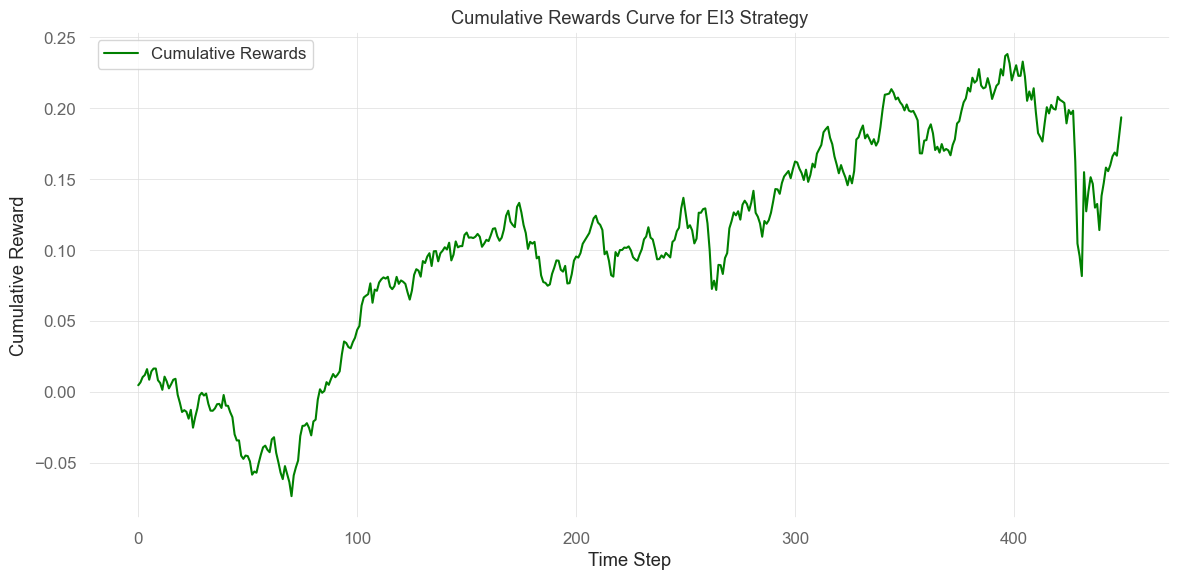

In [20]:
cumulative_rewards = np.cumsum(infosrewards)

# Plot the cumulative rewards curve
plt.figure(figsize=(12, 6))
plt.plot(cumulative_rewards, label="Cumulative Rewards", color="green")
plt.title("Cumulative Rewards Curve for EI3 Strategy")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()

## Benchmarks


In [21]:
# Get portfolio values
eiie_values = test_env._asset_memory["final"]
bh_values = []

In [22]:
# Calculate Buy & Hold
test_env.reset()
action = [1 / len(tickers)] * len(tickers)
done = False
while not done:  # Use test_env._done to check episode completion
    test_obs, rewards, terminated, truncated, info = test_env.step(action)
    done = terminated or truncated
    bh_values.append(test_env._portfolio_value)

Initial portfolio value:100000
Final portfolio value: 119504.4296875
Final accumulative portfolio value: 1.1950442790985107
Maximum DrawDown: -0.1432936109319084
Sharpe ratio: 0.8138792090179802


In [23]:
risk_free_rate = 0.043  # 4.3% annualized

In [24]:
# Calculate metrics
def calculate_metrics(values, risk_free_rate):
    returns = pd.Series(values).pct_change().dropna()
    cumulative_return = (values[-1] / values[0]) - 1
    annualized_return = (1 + cumulative_return) ** (252 / len(returns)) - 1
    volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = (annualized_return - risk_free_rate) / volatility
    max_drawdown = (values / np.maximum.accumulate(values) - 1).min()

    return {
        "Cumulative Return": cumulative_return,
        "Annualized Return": annualized_return,
        "Volatility": volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
    }


eiie_metrics = calculate_metrics(eiie_values, risk_free_rate)
bh_metrics = calculate_metrics(bh_values, risk_free_rate)

In [25]:
metrics = [
    "Cumulative Return",
    "Annualized Return",
    "Volatility",
    "Sharpe Ratio",
    "Max Drawdown",
]

metrics_df = pd.DataFrame(
    {
        "Metric": metrics,
        "EIIE": [eiie_metrics[m] for m in metrics],
        "Buy & Hold": [bh_metrics[m] for m in metrics],
    }
)

## Performance Summary


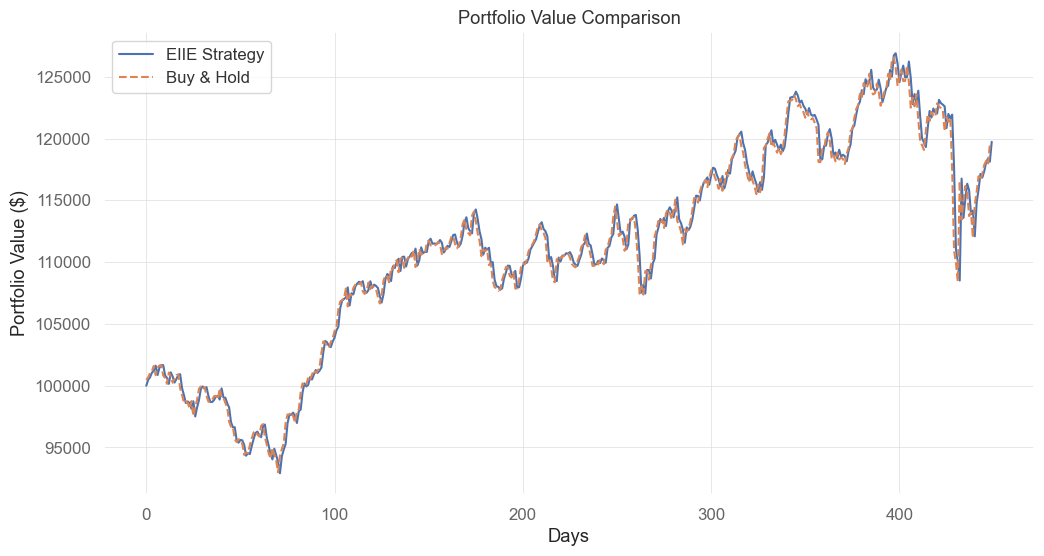

In [26]:
# Plot results
plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
plt.plot(eiie_values, label="EIIE Strategy")
plt.plot(bh_values, label="Buy & Hold", linestyle="--")
plt.title("Portfolio Value Comparison")
plt.xlabel("Days")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.show()
plt.close()

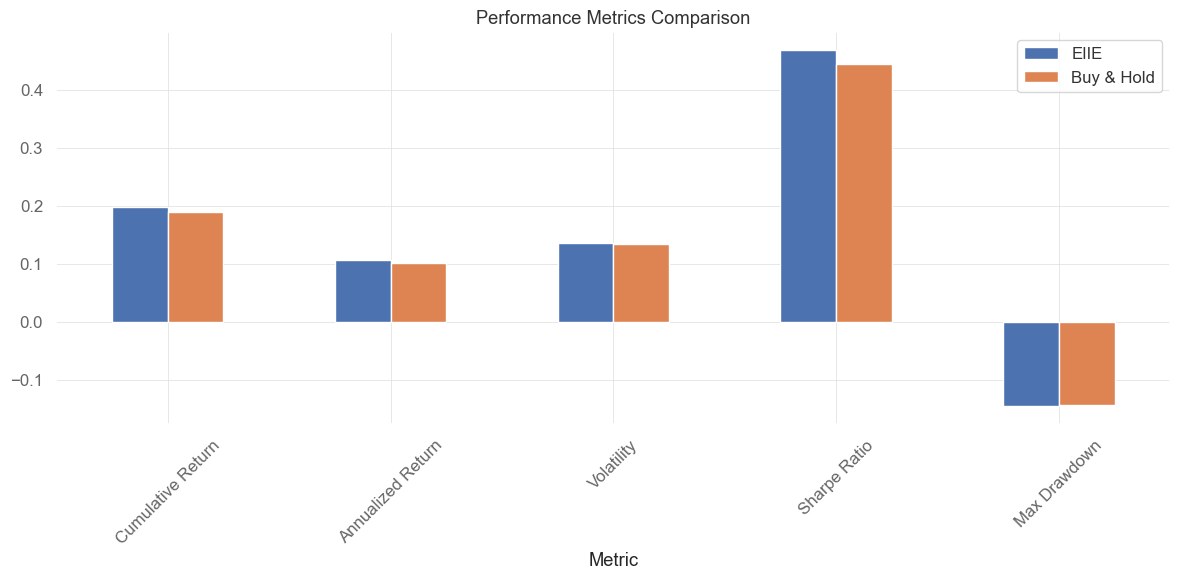

In [27]:
plt.figure(figsize=(12, 6))
metrics_df.set_index("Metric").plot(kind="bar", ax=plt.gca())
plt.title("Performance Metrics Comparison")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.close()

In [28]:
# Display metrics
print("\nPerformance Metrics:")
display(
    metrics_df.style.format(
        {
            "EIIE": "{:.2%}",
            "Buy & Hold": "{:.2%}",
            "Sharpe Ratio": "{:.2f}",
            "Volatility": "{:.2%}",
        }
    )
)


Performance Metrics:


,Metric,EIIE,Buy & Hold
0,Cumulative Return,19.73%,18.95%
1,Annualized Return,10.64%,10.23%
2,Volatility,13.53%,13.36%
3,Sharpe Ratio,46.84%,44.37%
4,Max Drawdown,-14.49%,-14.33%


In [29]:
# Additional Sharpe ratio optimization
log_returns = raw_df.pivot_table(index="date", columns="tic", values="close")
log_returns = np.log(log_returns.pct_change() + 1).dropna()
cov_matrix = log_returns.cov() * 252


def negative_sharpe(weights):
    port_return = np.dot(weights, log_returns.mean()) * 252
    port_vol = np.sqrt(weights.T @ cov_matrix @ weights)
    return -(port_return - risk_free_rate) / port_vol


constraints = {"type": "eq", "fun": lambda x: np.sum(x) - 1}
bounds = [(0, 1) for _ in tickers]
initial_weights = np.array([1 / len(tickers)] * len(tickers))

result = minimize(
    negative_sharpe,
    initial_weights,
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
)

print("\nOptimal Weights from Sharpe Ratio Optimization:")
for ticker, weight in zip(tickers, result.x):
    print(f"{ticker}: {weight:.2%}")


Optimal Weights from Sharpe Ratio Optimization:
AXP: 22.81%
AMGN: 0.00%
AAPL: 0.00%
BA: 0.00%
CAT: 3.58%
CSCO: 0.00%
CVX: 0.00%
GS: 0.00%
HD: 0.00%
HON: 0.00%
IBM: 6.72%
INTC: 0.00%
JNJ: 0.00%
KO: 0.00%
JPM: 0.00%
MCD: 0.00%
MMM: 0.00%
MRK: 0.00%
MSFT: 0.00%
NKE: 0.00%
PG: 0.00%
TRV: 14.00%
UNH: 0.00%
CRM: 0.00%
VZ: 0.00%
V: 0.00%
WBA: 0.00%
WMT: 0.00%
DIS: 0.00%
DOW: 52.89%
